<a href="https://colab.research.google.com/github/brendontj/CC-Fraud-Detection/blob/master/cc_fraud_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, mean_absolute_error, accuracy_score, plot_roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from math import sqrt

O conjunto de dados apresenta em suma dados numéricos obtidos após transformação PCA (Principal Component Analysis). Não foi possível obter os dados previamente a esta transformação.

Leitura do dataset de entrada com informações referentes a transações de cartão de crédito.

In [ ]:
data = pd.read_csv('creditcard.csv')
print('Quantidade de linhas do dataset {}'.format(data.shape[0]))
data.head()

Quantidade de linhas do dataset 284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Removemos os registros que apresentam features com valores faltantes
- Removemos a feature "time" por achar que a mesma não é relevante para predizer se uma transação é ou não fraudulenta

In [ ]:
df = data.dropna()
df = df.drop(columns="Time")
df['ID']= np.arange(1,len(df.Class)+1)
print('Quantidade de linhas do dataset sem valor Null/NaN/NaT {}'.format(df.shape[0]))
df.head()

Quantidade de linhas do dataset sem valor Null/NaN/NaT 284807


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,ID
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,3
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,5


Particionamos o dataset de entrada em 80% para o conjunto de treino e 20% para o conjunto de teste.

In [ ]:
x_train,  x_test, y_train, y_test = train_test_split(df.drop(['ID', 'Class'], axis=1), df['Class'], test_size=0.20, random_state = 0)
print('Dados de treino {}\n'.format(x_train.shape))
print('Dados de teste  {}\n'.format(x_test.shape))

Dados de treino (227845, 29)

Dados de teste  (56962, 29)



In [ ]:
df_train = x_train.copy()
df_train['Class'] = y_train
df_test = x_test.copy()
df_test['Class'] = y_test

Descrição estatística do conjunto de treino

In [ ]:
df_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,0.002930,-0.000877,-0.001470,0.001131,-0.001714,-0.001035,-0.000411,-0.001360,-0.000018,0.001496,-0.000732,-0.000990,0.000816,0.000992,0.000608,-0.000131,0.000657,-0.000735,0.000312,0.001775,0.000266,0.000300,-0.000276,0.000687,0.000192,-0.000584,-0.000574,-0.000135,88.630203,0.001716
std,1.955265,1.649672,1.515055,1.416360,1.365962,1.326404,1.225317,1.205508,1.099972,1.091091,1.019688,0.997871,0.997318,0.956432,0.915323,0.875836,0.850158,0.837698,0.815065,0.764878,0.737593,0.726705,0.623074,0.605268,0.520835,0.481943,0.401394,0.320750,248.037789,0.041390
min,-46.855047,-63.344698,-33.680984,-5.683171,-42.147898,-23.496714,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.553697,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-23.646890,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,-0.919898,-0.599013,-0.894424,-0.847412,-0.693585,-0.769201,-0.553573,-0.209145,-0.644499,-0.534165,-0.763115,-0.407805,-0.649363,-0.424852,-0.583393,-0.468316,-0.483629,-0.499053,-0.456435,-0.211511,-0.228658,-0.543193,-0.161766,-0.354153,-0.316644,-0.327647,-0.070776,-0.052865,5.690000,0.000000
50%,0.021886,0.063972,0.177138,-0.017538,-0.055515,-0.274916,0.039988,0.021545,-0.050353,-0.091912,-0.033716,0.139185,-0.013345,0.050754,0.049506,0.066979,-0.065926,-0.004297,0.004283,-0.062430,-0.028974,0.006970,-0.010914,0.041164,0.017429,-0.052443,0.001091,0.011171,22.000000,0.000000
75%,1.316871,0.802516,1.026049,0.744471,0.610153,0.397215,0.569938,0.325849,0.597788,0.457121,0.739265,0.618081,0.664465,0.493876,0.649587,0.522822,0.400096,0.499689,0.459840,0.133394,0.187107,0.529867,0.147642,0.439916,0.350742,0.240840,0.090529,0.078142,77.600000,0.000000
max,2.451888,22.057729,9.382558,16.875344,34.099309,23.917837,44.054461,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.825654,7.059132,9.207059,5.041069,5.572113,39.420904,27.202839,10.503090,22.528412,4.022866,7.519589,3.463246,12.152401,22.620072,19656.530000,1.000000


Descrição estatística do conjunto de teste

In [ ]:
df_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000
mean,-0.011720,0.003508,0.005881,-0.004524,0.006858,0.004139,0.001644,0.005440,0.000074,-0.005986,0.002927,0.003958,-0.003264,-0.003967,-0.002431,0.000523,-0.002629,0.002940,-0.001246,-0.007101,-0.001065,-0.001201,0.001104,-0.002750,-0.000767,0.002337,0.002295,0.000541,87.227297,0.001773
std,1.972334,1.657848,1.521044,1.413903,1.435957,1.355490,1.283130,1.148643,1.093268,1.079827,1.024805,1.004503,0.987058,0.967199,0.915292,0.877925,0.846048,0.840086,0.809937,0.794620,0.722125,0.721680,0.629978,0.607158,0.523049,0.483359,0.412459,0.365040,258.280642,0.042071
min,-56.407510,-72.715728,-48.325589,-5.600607,-113.743307,-26.160506,-23.189397,-50.943369,-8.630390,-17.141514,-4.568390,-18.683715,-3.835618,-18.049998,-4.391307,-13.303888,-22.883999,-9.287832,-4.353679,-54.497720,-22.665685,-8.483441,-32.828995,-2.836627,-8.696627,-1.855355,-8.878665,-15.430084,0.000000,0.000000
25%,-0.921972,-0.595792,-0.874649,-0.853267,-0.683487,-0.765653,-0.555542,-0.206208,-0.637058,-0.539031,-0.759576,-0.396268,-0.643496,-0.428579,-0.580244,-0.467537,-0.484584,-0.494712,-0.455365,-0.212744,-0.227182,-0.538917,-0.162292,-0.356309,-0.319498,-0.324004,-0.071012,-0.053511,5.460000,0.000000
50%,-0.002761,0.072712,0.191364,-0.028170,-0.050472,-0.271310,0.040576,0.025516,-0.053689,-0.097007,-0.028609,0.143534,-0.014759,0.049965,0.041602,0.063724,-0.064384,-0.001115,0.002028,-0.062617,-0.031747,0.006132,-0.012237,0.040072,0.013137,-0.050965,0.002251,0.011521,21.940000,0.000000
75%,1.309289,0.809015,1.031690,0.739049,0.619408,0.403661,0.572788,0.332808,0.594146,0.440694,0.741010,0.618570,0.652610,0.491192,0.645804,0.524908,0.397842,0.505740,0.454977,0.131808,0.183874,0.524395,0.147643,0.438394,0.350657,0.241285,0.093085,0.078844,76.000000,0.000000
max,2.454930,14.845545,4.079168,16.491217,34.801666,73.301626,120.589494,17.573712,9.272376,15.331742,11.228470,4.406338,7.126883,7.293226,8.877742,17.315112,9.253526,4.295648,5.591971,19.746453,22.579714,7.220158,19.002942,4.584549,5.521140,3.517346,31.612198,33.847808,25691.160000,1.000000


Contagem dos valores de cada classe. 0 indicando uma transação onde não há fraude e 1 indicando uma fraude.

In [ ]:
df_train['Class'].value_counts()

0    227454
1       391
Name: Class, dtype: int64

In [ ]:
df_test['Class'].value_counts()

0    56861
1      101
Name: Class, dtype: int64

Gráficos com a quantidade de cada classe nos conjuntos de dados

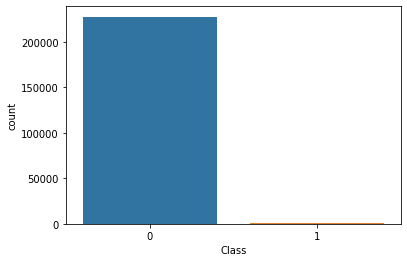

In [ ]:
ax = sns.countplot(x="Class", data=df_train)

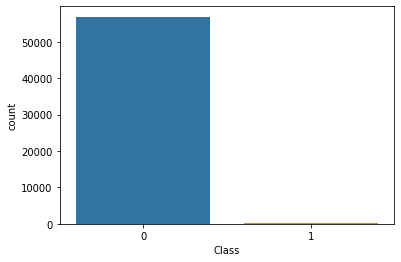

In [ ]:
bx = sns.countplot(x="Class", data=df_test)

In [ ]:
n_fraudulent_transactions = df_train['Class'].value_counts()[1]
print('Quantidade de transações fraudulentas no dataset de treino ({}) representando um total de ({})% do dataset'.format(n_fraudulent_transactions, (n_fraudulent_transactions/df_train.shape[0])*100))
n_fraudulent_transactions = df_test['Class'].value_counts()[1]
print('Quantidade de transações fraudulentas no dataset de teste ({}) representando um total de ({})% do dataset'.format(n_fraudulent_transactions, (n_fraudulent_transactions/df_test.shape[0])*100))

Quantidade de transações fraudulentas no dataset de treino (391) representando um total de (0.171607891329632)% do dataset
Quantidade de transações fraudulentas no dataset de teste (101) representando um total de (0.1773111899160844)% do dataset


Utilizamos o `mutual_info_classif` para estimar informações através de testes estatísticos, auxiliando na seleção de atributos que possuem forte relacionamento com a variável que estamos tentando prever.

In [ ]:
mic = mutual_info_classif(x_train, y_train)
mic

array([0.00223417, 0.00324333, 0.0048859 , 0.00493872, 0.0024805 ,
       0.00235812, 0.00385478, 0.00200889, 0.00420066, 0.00735391,
       0.00683457, 0.00754913, 0.00048603, 0.00795956, 0.00033733,
       0.00614541, 0.00819216, 0.00429184, 0.001477  , 0.00127442,
       0.00256113, 0.0004726 , 0.00081558, 0.00072547, 0.0006311 ,
       0.00054575, 0.00238648, 0.00180494, 0.00141945])

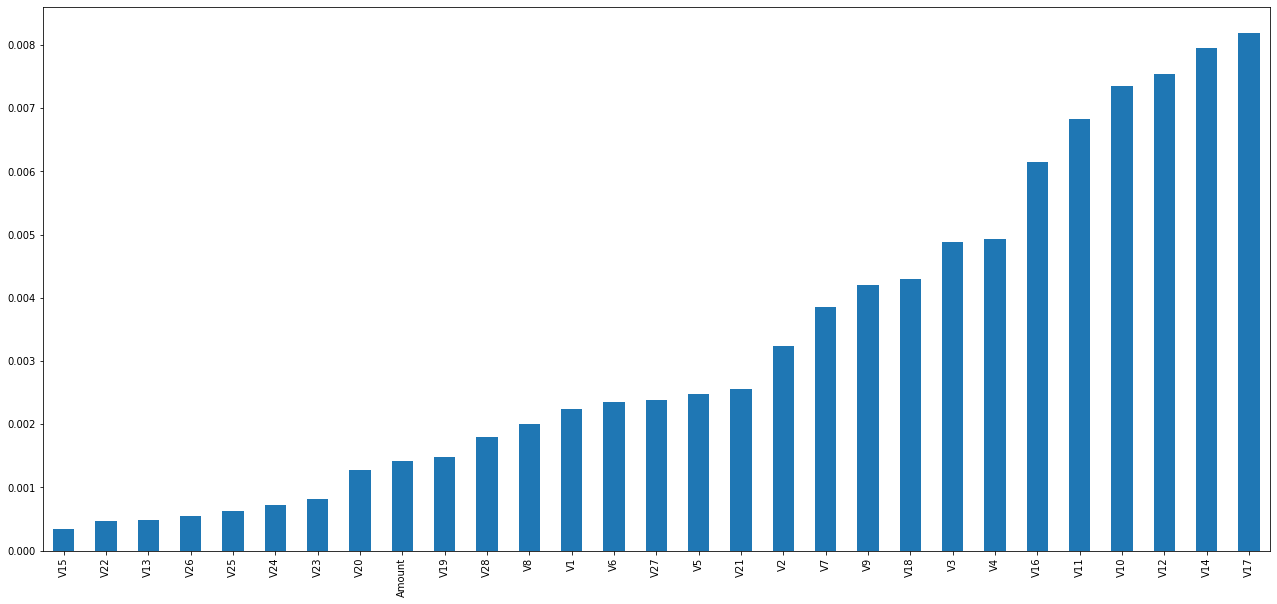

In [ ]:
mic = pd.Series(mic)
mic.index = x_train.columns
mic = mic.sort_values(ascending = True)
mic.plot.bar(figsize=(22,10))

Selecionamos as K variáveis que mais se relacionam com a coluna que indica a classificação da transação. `k=22`

In [ ]:
selection = SelectKBest(mutual_info_classif, k= 22).fit(x_train, y_train)
X_train = x_train[x_train.columns[selection.get_support()]]
X_test = x_test[x_test.columns[selection.get_support()]]

Função utilizada para gerar as curvas do K fold cross validation

In [ ]:
def plot_Kfold_cross_validation_curves(md, x_data, y_data):
  cv = StratifiedKFold(n_splits=5)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(x_data, y_data)):
      md.fit(x_data.iloc[train], y_data.iloc[train])
      viz = plot_roc_curve(md, x_data.iloc[test], y_data.iloc[test],
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="ROC for K fold cross-validation curves")
  ax.legend(loc="lower right")
  plt.show()

# Random Forest

Utilizaremos a classe padrão do classificador Random Forest, não utilizamos variações na parametrização da classe devido a obtenção de um resultado satisfatório com os parâmetros padrões.  

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Treino

Relatório de classificação da predição com o modelo Random forest com o sample de treino

In [ ]:
predictions = rf.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       1.00      1.00      1.00       391

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



Matriz de confusão dos valores preditos com o conjunto de treino

In [ ]:
pd.crosstab(y_train, predictions, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,227454,0,227454
1,0,391,391
All,227454,391,227845


Scores das validações cruzadas

In [ ]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
scores

array([0.99958305, 0.99945138, 0.99956111, 0.99958305, 0.99949527])

Media dos scores obtidos das validações cruzadas

In [ ]:
scores.mean()

0.9995347714455003

Acurácia das predições com base no conjunto de treino

In [ ]:
accuracy_score(y_train, predictions)

1.0

Erro absoluto com base no conjunto de treino




In [ ]:
e = mean_absolute_error(y_train, predictions)
e

0.0

Curva ROC

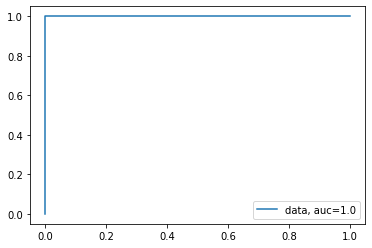

In [ ]:
fpr, tpr, _ = roc_curve(y_train, predictions)
roc_auc_scr =  roc_auc_score(y_train, predictions)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show() 

Curvas da K fold cross-validation

In [ ]:
plot_Kfold_cross_validation_curves(rf, X_train, y_train)

## Teste

Predição com o sample de teste

In [ ]:
predictions_test = rf.predict(X_test)

Relatório de classificação da predição com o modelo Random forest com o sample de teste



In [ ]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.93      0.76      0.84       101

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Matriz de confusão dos valores preditos com o conjunto de teste

In [ ]:
pd.crosstab(y_test, predictions_test, rownames=['Real'],colnames=['Predito'],margins=True) 

Predito,0,1,All
Real,,,
0,56855,6,56861
1,24,77,101
All,56879,83,56962


Validação cruzada utilizando 5 pastas com conjunto de teste

In [ ]:
scores = cross_val_score(rf, X_test, predictions_test, cv=5, scoring='accuracy')
scores

array([0.99973668, 0.99964891, 0.99982444, 0.9995611 , 0.99991222])

Media dos scores obtidos com o conjunto de teste

In [ ]:
scores.mean()

0.9997366680901045

Acurácia do modelo

In [ ]:
accuracy_score(y_test, predictions_test)

0.9994733330992591

Mean Absolute Error

In [1]:
e = mean_absolute_error(y_test, predictions_test)
e

NameError: ignored

Curva ROC com o conjunto de teste

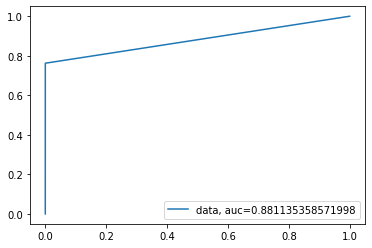

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predictions_test)
roc_auc_scr =  roc_auc_score(y_test, predictions_test)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

Curvas da K fold cross-validation com os dados de teste

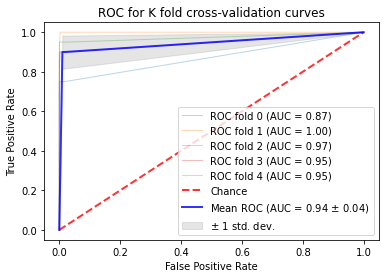

In [ ]:
plot_Kfold_cross_validation_curves(rf, X_test, y_test)

# KNN 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Treino

In [ ]:
y_pred = knn.predict(X_train)

In [ ]:
accuracy_score(y_train, y_pred)

1.0

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       1.00      1.00      1.00       391

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



In [ ]:
pd.crosstab(y_train, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,227454,0,227454
1,0,391,391
All,227454,391,227845


In [ ]:
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
scores

array([0.99931971, 0.9993636 , 0.99958305, 0.99947333, 0.99938555])

In [ ]:
scores.mean()

0.9994250477298163

In [ ]:
accuracy_score(y_train, y_pred)

1.0

Mean Absolute Error 

In [ ]:
e = mean_absolute_error(y_test, predictions_test)
e

0.0

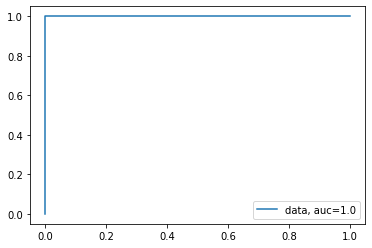

In [ ]:
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc_scr =  roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

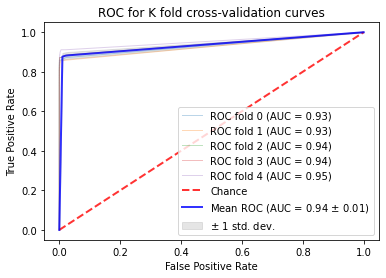

In [ ]:
plot_Kfold_cross_validation_curves(knn, X_train, y_train)

## Teste

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.83      0.84      0.84       101

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,56844,17,56861
1,16,85,101
All,56860,102,56962


In [ ]:
scores = cross_val_score(knn, X_test, y_test, cv=5, scoring='accuracy')
scores

array([0.99921004, 0.99921004, 0.99947331, 0.99929775, 0.99938553])

In [ ]:
scores.mean()

0.9993153367260795

In [ ]:
accuracy_score(y_test, y_pred)

0.999420666409185

In [ ]:
e = mean_absolute_error(y_test, y_pred)
e

0.024069349613459214

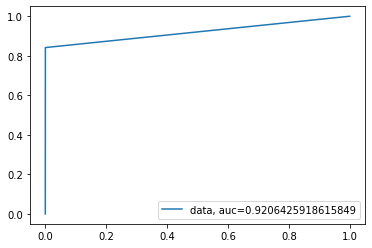

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_scr =  roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

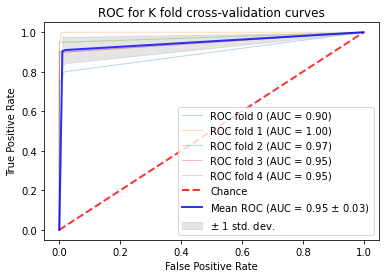

In [ ]:
plot_Kfold_cross_validation_curves(knn, X_test, y_test)

# MLPClassifier

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=5, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

## Treino

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

Iteration 1, loss = 0.04244978
Iteration 2, loss = 0.00829890
Iteration 3, loss = 0.00563703
Iteration 4, loss = 0.00479990
Iteration 5, loss = 0.00429235
Iteration 6, loss = 0.00395833
Iteration 7, loss = 0.00375664
Iteration 8, loss = 0.00362084
Iteration 9, loss = 0.00351762
Iteration 10, loss = 0.00343677
Iteration 11, loss = 0.00337154
Iteration 12, loss = 0.00331430
Iteration 13, loss = 0.00326904
Iteration 14, loss = 0.00322650
Iteration 15, loss = 0.00318938
Iteration 16, loss = 0.00315607
Iteration 17, loss = 0.00312760
Iteration 18, loss = 0.00309957
Iteration 19, loss = 0.00307508
Iteration 20, loss = 0.00305012
Iteration 21, loss = 0.00303077
Iteration 22, loss = 0.00301150
Iteration 23, loss = 0.00299291
Iteration 24, loss = 0.00297530
Iteration 25, loss = 0.00295769
Iteration 26, loss = 0.00294334
Iteration 27, loss = 0.00292779
Iteration 28, loss = 0.00290925
Iteration 29, loss = 0.00290190
Iteration 30, loss = 0.00288652
Iteration 31, loss = 0.00287413
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
 print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.98      0.83      0.90       391

    accuracy                           1.00    227845
   macro avg       0.99      0.92      0.95    227845
weighted avg       1.00      1.00      1.00    227845



In [ ]:
pd.crosstab(y_train, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,227449,5,227454
1,65,326,391
All,227514,331,227845


In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
scores

Iteration 1, loss = 0.04987033
Iteration 2, loss = 0.01057886
Iteration 3, loss = 0.00630915
Iteration 4, loss = 0.00519143
Iteration 5, loss = 0.00461956
Iteration 6, loss = 0.00422056
Iteration 7, loss = 0.00394277
Iteration 8, loss = 0.00376162
Iteration 9, loss = 0.00363344
Iteration 10, loss = 0.00353383
Iteration 11, loss = 0.00345542
Iteration 12, loss = 0.00339440
Iteration 13, loss = 0.00333952
Iteration 14, loss = 0.00329475
Iteration 15, loss = 0.00325247
Iteration 16, loss = 0.00321732
Iteration 17, loss = 0.00318400
Iteration 18, loss = 0.00315636
Iteration 19, loss = 0.00312826
Iteration 20, loss = 0.00310421
Iteration 21, loss = 0.00308048
Iteration 22, loss = 0.00305846
Iteration 23, loss = 0.00303751
Iteration 24, loss = 0.00301834
Iteration 25, loss = 0.00300158
Iteration 26, loss = 0.00298458
Iteration 27, loss = 0.00296686
Iteration 28, loss = 0.00295328
Iteration 29, loss = 0.00293816
Iteration 30, loss = 0.00292335
Iteration 31, loss = 0.00290950
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04966211
Iteration 2, loss = 0.01061891
Iteration 3, loss = 0.00635949
Iteration 4, loss = 0.00524281
Iteration 5, loss = 0.00466406
Iteration 6, loss = 0.00426219
Iteration 7, loss = 0.00398104
Iteration 8, loss = 0.00379670
Iteration 9, loss = 0.00366399
Iteration 10, loss = 0.00356087
Iteration 11, loss = 0.00347724
Iteration 12, loss = 0.00340882
Iteration 13, loss = 0.00334773
Iteration 14, loss = 0.00329705
Iteration 15, loss = 0.00325200
Iteration 16, loss = 0.00321062
Iteration 17, loss = 0.00317387
Iteration 18, loss = 0.00314203
Iteration 19, loss = 0.00311024
Iteration 20, loss = 0.00308395
Iteration 21, loss = 0.00305859
Iteration 22, loss = 0.00303547
Iteration 23, loss = 0.00301373
Iteration 24, loss = 0.00299296
Iteration 25, loss = 0.00297488
Iteration 26, loss = 0.00295809
Iteration 27, loss = 0.00293953
Iteration 28, loss = 0.00292459
Iteration 29, loss = 0.00290932
Iteration 30, loss = 0.00289371
Iteration 31, loss = 0.00287940
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04950052
Iteration 2, loss = 0.01072154
Iteration 3, loss = 0.00642264
Iteration 4, loss = 0.00530931
Iteration 5, loss = 0.00474779
Iteration 6, loss = 0.00438534
Iteration 7, loss = 0.00411292
Iteration 8, loss = 0.00390840
Iteration 9, loss = 0.00376181
Iteration 10, loss = 0.00365218
Iteration 11, loss = 0.00356497
Iteration 12, loss = 0.00349253
Iteration 13, loss = 0.00343027
Iteration 14, loss = 0.00337830
Iteration 15, loss = 0.00333255
Iteration 16, loss = 0.00329169
Iteration 17, loss = 0.00325485
Iteration 18, loss = 0.00322044
Iteration 19, loss = 0.00318997
Iteration 20, loss = 0.00316283
Iteration 21, loss = 0.00313717
Iteration 22, loss = 0.00311363
Iteration 23, loss = 0.00309097
Iteration 24, loss = 0.00306989
Iteration 25, loss = 0.00305164
Iteration 26, loss = 0.00303265
Iteration 27, loss = 0.00301581
Iteration 28, loss = 0.00299868
Iteration 29, loss = 0.00298391
Iteration 30, loss = 0.00296858
Iteration 31, loss = 0.00295432
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04954796
Iteration 2, loss = 0.01080026
Iteration 3, loss = 0.00645720
Iteration 4, loss = 0.00536167
Iteration 5, loss = 0.00476824
Iteration 6, loss = 0.00436350
Iteration 7, loss = 0.00406046
Iteration 8, loss = 0.00385032
Iteration 9, loss = 0.00370278
Iteration 10, loss = 0.00359190
Iteration 11, loss = 0.00350706
Iteration 12, loss = 0.00343516
Iteration 13, loss = 0.00337599
Iteration 14, loss = 0.00332510
Iteration 15, loss = 0.00327955
Iteration 16, loss = 0.00324178
Iteration 17, loss = 0.00320684
Iteration 18, loss = 0.00317582
Iteration 19, loss = 0.00314617
Iteration 20, loss = 0.00312182
Iteration 21, loss = 0.00309660
Iteration 22, loss = 0.00307547
Iteration 23, loss = 0.00305454
Iteration 24, loss = 0.00303561
Iteration 25, loss = 0.00301940
Iteration 26, loss = 0.00300141
Iteration 27, loss = 0.00298659
Iteration 28, loss = 0.00297198
Iteration 29, loss = 0.00295600
Iteration 30, loss = 0.00294556
Iteration 31, loss = 0.00293099
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04995278
Iteration 2, loss = 0.01049265
Iteration 3, loss = 0.00641410
Iteration 4, loss = 0.00533048
Iteration 5, loss = 0.00472529
Iteration 6, loss = 0.00430991
Iteration 7, loss = 0.00404708
Iteration 8, loss = 0.00388009
Iteration 9, loss = 0.00375875
Iteration 10, loss = 0.00366153
Iteration 11, loss = 0.00358169
Iteration 12, loss = 0.00351625
Iteration 13, loss = 0.00346014
Iteration 14, loss = 0.00340968
Iteration 15, loss = 0.00336502
Iteration 16, loss = 0.00332822
Iteration 17, loss = 0.00329254
Iteration 18, loss = 0.00326331
Iteration 19, loss = 0.00323278
Iteration 20, loss = 0.00320852
Iteration 21, loss = 0.00318440
Iteration 22, loss = 0.00316198
Iteration 23, loss = 0.00314074
Iteration 24, loss = 0.00312179
Iteration 25, loss = 0.00310352
Iteration 26, loss = 0.00308405
Iteration 27, loss = 0.00306821
Iteration 28, loss = 0.00305112
Iteration 29, loss = 0.00303626
Iteration 30, loss = 0.00302156
Iteration 31, loss = 0.00300543
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([0.99940749, 0.99940749, 0.99967083, 0.99953916, 0.99949527])

In [ ]:
scores.mean()

0.9995040488051087

In [ ]:
accuracy_score(y_train, y_pred)

0.9996927735960851

In [ ]:
e = mean_absolute_error(y_train, y_pred)
e

0.017527875054179905

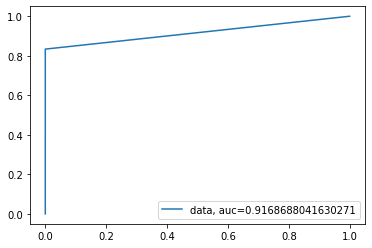

In [ ]:
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc_scr =  roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

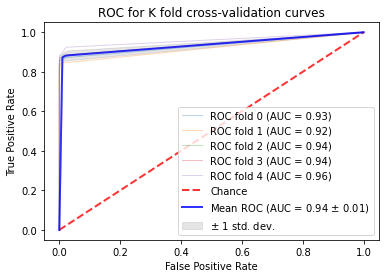

In [ ]:
plot_Kfold_cross_validation_curves(clf, X_train, y_train)

## Teste

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.90      0.79      0.84       101

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,56852,9,56861
1,21,80,101
All,56873,89,56962


In [ ]:
scores = cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy')
scores

Iteration 1, loss = 0.11955600
Iteration 2, loss = 0.03328487
Iteration 3, loss = 0.02343788
Iteration 4, loss = 0.01671484
Iteration 5, loss = 0.01170198
Iteration 6, loss = 0.00864085
Iteration 7, loss = 0.00708913
Iteration 8, loss = 0.00621434
Iteration 9, loss = 0.00564452
Iteration 10, loss = 0.00524036
Iteration 11, loss = 0.00493367
Iteration 12, loss = 0.00469556
Iteration 13, loss = 0.00450098
Iteration 14, loss = 0.00433518
Iteration 15, loss = 0.00419662
Iteration 16, loss = 0.00407794
Iteration 17, loss = 0.00397447
Iteration 18, loss = 0.00388413
Iteration 19, loss = 0.00379896
Iteration 20, loss = 0.00372779
Iteration 21, loss = 0.00366094
Iteration 22, loss = 0.00360149
Iteration 23, loss = 0.00354444
Iteration 24, loss = 0.00349455
Iteration 25, loss = 0.00344525
Iteration 26, loss = 0.00339968
Iteration 27, loss = 0.00335828
Iteration 28, loss = 0.00331770
Iteration 29, loss = 0.00328234
Iteration 30, loss = 0.00324803
Iteration 31, loss = 0.00321755
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.11813124
Iteration 2, loss = 0.03274154
Iteration 3, loss = 0.02376655
Iteration 4, loss = 0.01773532
Iteration 5, loss = 0.01307145
Iteration 6, loss = 0.00980493
Iteration 7, loss = 0.00793471
Iteration 8, loss = 0.00689879
Iteration 9, loss = 0.00623584
Iteration 10, loss = 0.00577611
Iteration 11, loss = 0.00543010
Iteration 12, loss = 0.00516494
Iteration 13, loss = 0.00495282
Iteration 14, loss = 0.00477859
Iteration 15, loss = 0.00463730
Iteration 16, loss = 0.00451497
Iteration 17, loss = 0.00440929
Iteration 18, loss = 0.00431940
Iteration 19, loss = 0.00424041
Iteration 20, loss = 0.00416887
Iteration 21, loss = 0.00410603
Iteration 22, loss = 0.00404813
Iteration 23, loss = 0.00399275
Iteration 24, loss = 0.00394556
Iteration 25, loss = 0.00389655
Iteration 26, loss = 0.00385412
Iteration 27, loss = 0.00381546
Iteration 28, loss = 0.00377465
Iteration 29, loss = 0.00374044
Iteration 30, loss = 0.00370841
Iteration 31, loss = 0.00367841
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.11886009
Iteration 2, loss = 0.03352293
Iteration 3, loss = 0.02420574
Iteration 4, loss = 0.01797205
Iteration 5, loss = 0.01322601
Iteration 6, loss = 0.00992417
Iteration 7, loss = 0.00813121
Iteration 8, loss = 0.00715057
Iteration 9, loss = 0.00652100
Iteration 10, loss = 0.00608284
Iteration 11, loss = 0.00575563
Iteration 12, loss = 0.00549972
Iteration 13, loss = 0.00529118
Iteration 14, loss = 0.00511816
Iteration 15, loss = 0.00497323
Iteration 16, loss = 0.00484702
Iteration 17, loss = 0.00474032
Iteration 18, loss = 0.00464473
Iteration 19, loss = 0.00455728
Iteration 20, loss = 0.00448060
Iteration 21, loss = 0.00440818
Iteration 22, loss = 0.00434445
Iteration 23, loss = 0.00428405
Iteration 24, loss = 0.00422730
Iteration 25, loss = 0.00417646
Iteration 26, loss = 0.00412818
Iteration 27, loss = 0.00408334
Iteration 28, loss = 0.00404272
Iteration 29, loss = 0.00400237
Iteration 30, loss = 0.00396449
Iteration 31, loss = 0.00392914
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.11891134
Iteration 2, loss = 0.03341747
Iteration 3, loss = 0.02406298
Iteration 4, loss = 0.01771733
Iteration 5, loss = 0.01289599
Iteration 6, loss = 0.00954125
Iteration 7, loss = 0.00766783
Iteration 8, loss = 0.00662321
Iteration 9, loss = 0.00595577
Iteration 10, loss = 0.00548840
Iteration 11, loss = 0.00514383
Iteration 12, loss = 0.00487500
Iteration 13, loss = 0.00465981
Iteration 14, loss = 0.00448436
Iteration 15, loss = 0.00433652
Iteration 16, loss = 0.00421156
Iteration 17, loss = 0.00410368
Iteration 18, loss = 0.00401124
Iteration 19, loss = 0.00392817
Iteration 20, loss = 0.00385656
Iteration 21, loss = 0.00378874
Iteration 22, loss = 0.00372650
Iteration 23, loss = 0.00367065
Iteration 24, loss = 0.00361738
Iteration 25, loss = 0.00357009
Iteration 26, loss = 0.00352649
Iteration 27, loss = 0.00348389
Iteration 28, loss = 0.00344493
Iteration 29, loss = 0.00340728
Iteration 30, loss = 0.00337115
Iteration 31, loss = 0.00333847
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.11964504
Iteration 2, loss = 0.03368172
Iteration 3, loss = 0.02377944
Iteration 4, loss = 0.01704302
Iteration 5, loss = 0.01210994
Iteration 6, loss = 0.00896331
Iteration 7, loss = 0.00737535
Iteration 8, loss = 0.00649323
Iteration 9, loss = 0.00591584
Iteration 10, loss = 0.00551056
Iteration 11, loss = 0.00520564
Iteration 12, loss = 0.00496639
Iteration 13, loss = 0.00477185
Iteration 14, loss = 0.00460872
Iteration 15, loss = 0.00447351
Iteration 16, loss = 0.00435537
Iteration 17, loss = 0.00425304
Iteration 18, loss = 0.00416032
Iteration 19, loss = 0.00407802
Iteration 20, loss = 0.00400514
Iteration 21, loss = 0.00393742
Iteration 22, loss = 0.00387062
Iteration 23, loss = 0.00381506
Iteration 24, loss = 0.00375870
Iteration 25, loss = 0.00371018
Iteration 26, loss = 0.00366317
Iteration 27, loss = 0.00361846
Iteration 28, loss = 0.00357724
Iteration 29, loss = 0.00353794
Iteration 30, loss = 0.00350160
Iteration 31, loss = 0.00346617
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([0.99929781, 0.99956113, 0.99973666, 0.99912219, 0.99964888])

In [ ]:
scores.mean()

0.9994733346392473

In [ ]:
accuracy_score(y_test, y_pred)

0.9994733330992591

In [ ]:
e = mean_absolute_error(y_test, y_pred)
e

0.022949224403906218

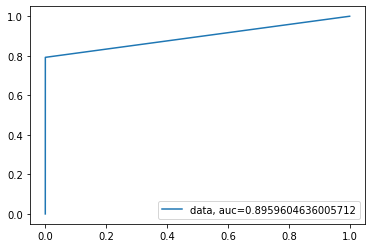

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_scr =  roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

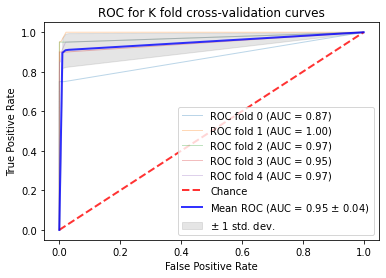

In [ ]:
plot_Kfold_cross_validation_curves(clf, X_test, y_test)